In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
train_images = glob('./images/Train_*.jpg')
test_images = glob('./images/Test_*.jpg')

print('number train images: ', len(train_images))
print('number test images: ', len(test_images))

number train images:  1821
number test images:  1821


(1365, 2048, 3)
(1365, 2048, 3)


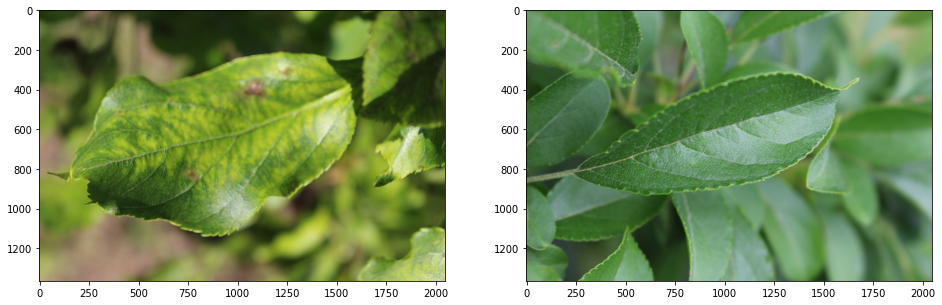

In [3]:
def read_image(file):
    raw = tf.io.read_file(file)
    image = tf.io.decode_jpeg(raw)
    image = tf.cast(image, tf.float32) / 255.0
    return image


image = read_image('./images/Train_0.jpg')
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
print(image.shape)

image = read_image('./images/Train_100.jpg')
plt.subplot(1, 2, 2)
plt.imshow(image)

print(image.shape)
plt.show()

(1365, 2048, 3)
(1365, 2048, 3)


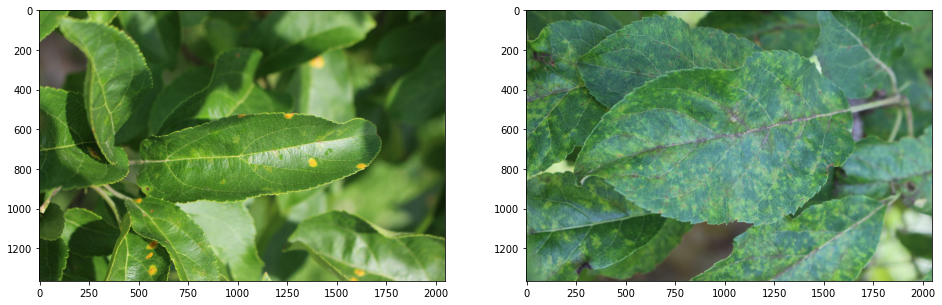

In [4]:
image = read_image('./images/Test_0.jpg')
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
print(image.shape)

image = read_image('./images/Test_100.jpg')
plt.subplot(1, 2, 2)
plt.imshow(image)

print(image.shape)
plt.show()

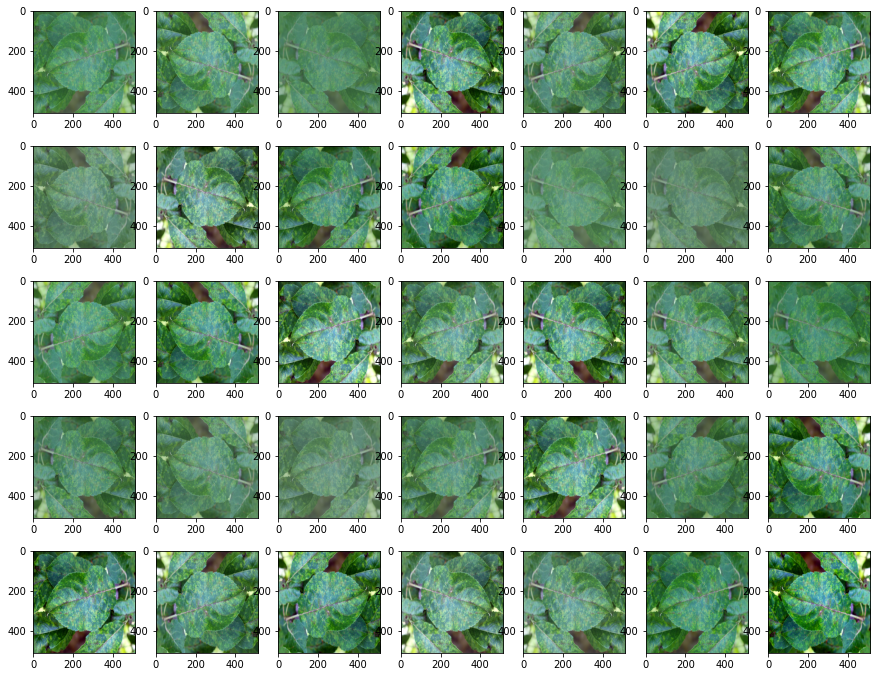

In [5]:
INPUT_SIZE = (512, 512)
RATIO = 2048.0 / 1365.0
SCALE_UP = 1.3


def random_flip(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image


def random_crop(image):
    target_size = [int(INPUT_SIZE[0] * RATIO), INPUT_SIZE[0]]
    image = tf.image.resize(image, [int(target_size[0] * SCALE_UP), int(target_size[1] * SCALE_UP)],
                            tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, [target_size[0], target_size[1], 3])
    return image


@tf.function
def random_rotate(image):
    p = tf.random.uniform((), 0, 1.0)
    if p < 0.25:
        image = tf.image.rot90(image, 1)
    elif p < 0.5:
        image = tf.image.rot90(image, 2)
    elif p < 0.75:
        image = tf.image.rot90(image, 3)
    return image


def random_jitter(image):
    image = tf.cast(image, tf.float32)
    # image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_contrast(image, 0.5, 1.6)
    # image = tf.image.adjust_contrast(image, 1.6)
    image = tf.image.random_saturation(image, 0.8, 1.3)
    # image = tf.image.adjust_saturation(image, 1.3)
    image = tf.image.random_brightness(image, 0.03)
    # image = tf.image.adjust_brightness(image, -0.03)
    image = tf.clip_by_value(image, 0, 1.0)
    return image


@tf.function
def random_process(image):
    image = random_flip(image)
    # if tf.random.uniform((), 0, 1.0) > 0.1:
    #     image = random_crop(image)
    image = tf.image.resize(image, [INPUT_SIZE[0], INPUT_SIZE[0]])
    # image = random_rotate(image)
    image = random_jitter(image)
    return image


plt.figure(figsize=(15, 12))
for n in range(35):
    test_image = random_process(image)
    plt.subplot(5, 7, n+1)
    plt.imshow(test_image)
    # plt.axis('off')

plt.show()

In [6]:
def get_train_valid_split(csv, train_percent=0.85, seed=None):
    csv = pd.read_csv(csv)
    images = []
    labels = []
    for row in csv.values:
        images.append('./images/' + row[0] + '.jpg')
        labels.append(row[1:])
    assert len(images) == len(labels)
    
    pair = [(images[i], labels[i]) for i in range(len(images))]
    np.random.seed(seed)
    np.random.shuffle(pair)
    
    train_size = int(len(images) * train_percent)
    train_images = [p[0] for p in pair[:train_size]]
    train_labels = [p[1] for p in pair[:train_size]]
    valid_images = [p[0] for p in pair[train_size:]]
    valid_labels = [p[1] for p in pair[train_size:]]
    
    print('train size: ', len(train_images))
    print('valid size: ', len(valid_images))
    
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
    return train_ds, valid_ds


def train_pipeline(image_path, label):
    image = read_image(image_path)
    return random_process(image), label


def valid_pipeline(image_path, label):
    image = read_image(image_path)
    image = tf.image.resize(image, INPUT_SIZE)
    return image, label


BATCH_SIZE = 4
train_ds, valid_ds = get_train_valid_split('./train.csv', seed=1000)
print(train_ds)
print(valid_ds)

train_ds = train_ds.map(train_pipeline).shuffle(200).batch(BATCH_SIZE)
valid_ds = valid_ds.map(valid_pipeline).shuffle(200).batch(BATCH_SIZE)
print(train_ds)
print(valid_ds)

train size:  1547
valid size:  274
<TensorSliceDataset shapes: ((), (4,)), types: (tf.string, tf.int32)>
<TensorSliceDataset shapes: ((), (4,)), types: (tf.string, tf.int32)>
<BatchDataset shapes: ((None, 512, 512, None), (None, 4)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 512, 512, None), (None, 4)), types: (tf.float32, tf.int32)>


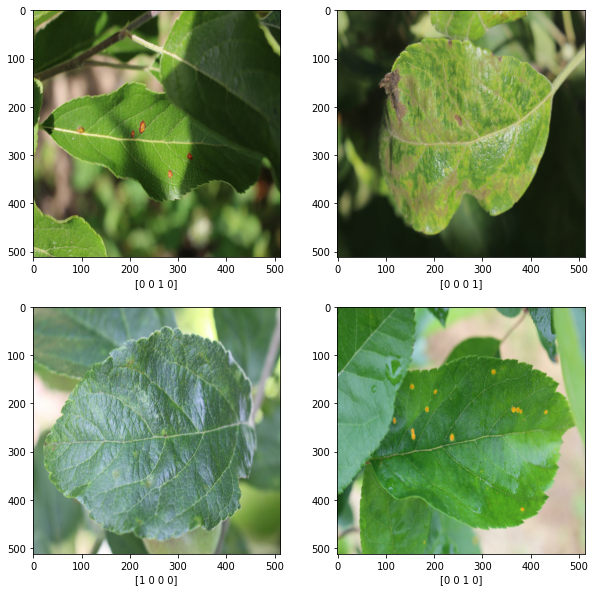

In [7]:
train_iter = iter(train_ds)
valid_iter = iter(valid_ds)

train_image_batch, train_label_batch = next(train_iter)
valid_image_batch, valid_label_batch = next(valid_iter)

plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(2, 2, i+1)
    plt.imshow(train_image_batch[i])
    plt.xlabel(str(train_label_batch[i].numpy()))
    plt.subplot(2, 2, i+3)
    plt.imshow(valid_image_batch[i])
    plt.xlabel(str(valid_label_batch[i].numpy()))
plt.show()

In [8]:
def build_baseline():
    model = keras.Sequential([
        keras.applications.DenseNet121(input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 3],
                                       weights='imagenet',
                                       include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    return model



keras.backend.clear_session()
model = build_baseline()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [9]:
def schedule(epoch, current_lr):
    if epoch == 20:
        return 1e-4
    elif epoch == 40:
        return 2.5e-5
    elif epoch == 60:
        return 3.5e-6
    return current_lr


lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=True)
tensorboard_callback = keras.callbacks.TensorBoard()

In [10]:
history = model.fit(train_ds,
                    epochs=60,
                    validation_data=valid_ds,
                    callbacks=[lr_scheduler, tensorboard_callback])

Train for 387 steps, validate for 69 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/60
387/387 [==============================] - 75s 194ms/step - loss: 0.9775 - categorical_accuracy: 0.6348 - val_loss: 2.7920 - val_categorical_accuracy: 0.6204

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/60
387/387 [==============================] - 59s 154ms/step - loss: 0.8023 - categorical_accuracy: 0.7104 - val_loss: 0.7767 - val_categorical_accuracy: 0.7482

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/60
387/387 [==============================] - 60s 154ms/step - loss: 0.7210 - categorical_accuracy: 0.7576 - val_loss: 0.7851 - val_categorical_accuracy: 0.7153

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/60
387/387 [==============================] - 60s 154ms/step - loss: 0.6901 - categorical_accuracy: 0.

387/387 [==============================] - 59s 153ms/step - loss: 0.1119 - categorical_accuracy: 0.9638 - val_loss: 0.1771 - val_categorical_accuracy: 0.9380

Epoch 00034: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 34/60
387/387 [==============================] - 59s 153ms/step - loss: 0.1240 - categorical_accuracy: 0.9619 - val_loss: 0.1856 - val_categorical_accuracy: 0.9307

Epoch 00035: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 35/60
387/387 [==============================] - 59s 153ms/step - loss: 0.1172 - categorical_accuracy: 0.9657 - val_loss: 0.1675 - val_categorical_accuracy: 0.9380

Epoch 00036: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 36/60
387/387 [==============================] - 59s 153ms/step - loss: 0.1027 - categorical_accuracy: 0.9664 - val_loss: 0.1823 - val_categorical_accuracy: 0.9270

Epoch 00037: LearningRateScheduler reducing learning rate to 9.9999997473787

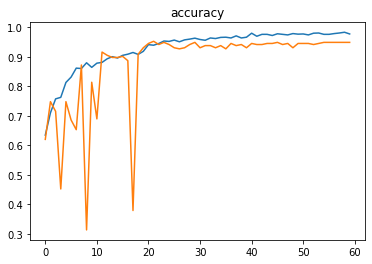

In [11]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('accuracy')
plt.show()

In [12]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../../checkpoint/plant-pathology/baseline.checkpoint')

'../../checkpoint/plant-pathology/baseline.checkpoint-1'

In [13]:
# checkpoint = tf.train.Checkpoint()
# if os.path.isdir('../../checkpoint/plant-pathology/'):
#     print('restoring checkpoint...')
#     checkpoint.restore('../../checkpoint/plant-pathology/baseline.checkpoint-1')

In [14]:
def submission(submission):
    csv = pd.read_csv('./sample_submission.csv')
    for i in range(len(csv)):
        row = csv.iloc[i]
        image = read_image('./images/' + row[0] + '.jpg')
        image = tf.image.resize(image, INPUT_SIZE)
        image = image[tf.newaxis, ...]
        results = model.predict(image)
        csv.iloc[i, 1:] = results[0]
        print('\rprocessed: %d/%d' % (i+1, len(csv)), end='')
    print()
    csv.to_csv(submission, index=False)
    print(csv.head())


submission('baseline.csv')

processed: 1821/1821
  image_id       healthy  multiple_diseases          rust          scab
0   Test_0  2.501252e-07           0.027744  9.722561e-01  1.729551e-08
1   Test_1  4.852805e-06           0.005505  9.944901e-01  2.085404e-08
2   Test_2  2.048497e-06           0.000763  2.577390e-07  9.992352e-01
3   Test_3  9.921528e-01           0.000858  4.221336e-03  2.767888e-03
4   Test_4  1.289004e-06           0.006227  9.937722e-01  3.028867e-10


In [15]:
def diff():
    csv1 = pd.read_csv('submission.csv')
    csv2 = pd.read_csv('baseline.csv')
    diff = 0
    for i in range(len(csv1)):
        row1 = csv1.values[i, 1:]
        row2 = csv2.values[i, 1:]
        result1 = np.argmax(row1)
        result2 = np.argmax(row2)
        if result1 != result2:
            diff += 1
    print('diff: %d/%d' % (diff, len(csv1)))

diff()

diff: 161/1821
